2025-06-27 20:38:50.501697: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4 Pro
2025-06-27 20:38:50.501732: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 48.00 GB
2025-06-27 20:38:50.501735: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 18.00 GB
2025-06-27 20:38:50.501747: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-06-27 20:38:50.501755: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


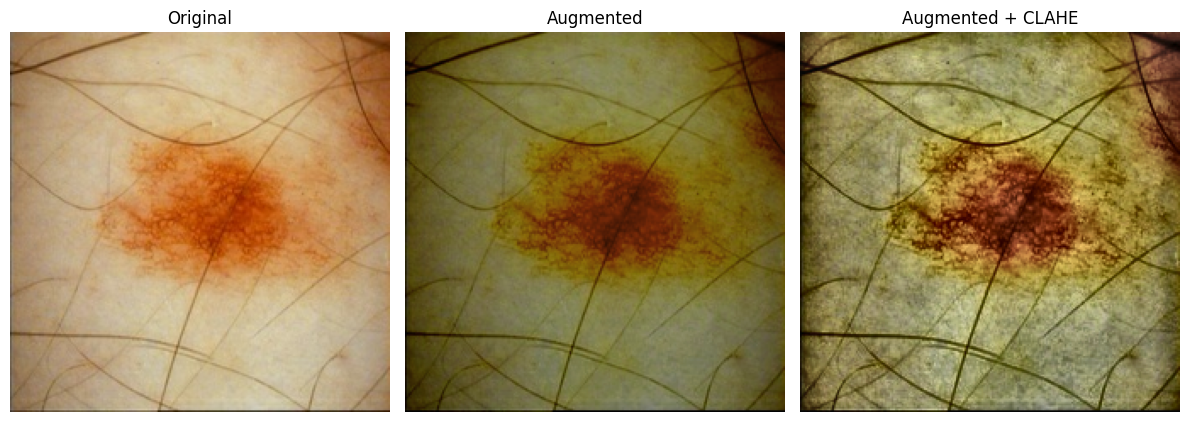

In [1]:
import tensorflow as tf
import numpy as np
import cv2
import albumentations as A
import matplotlib.pyplot as plt
from pathlib import Path

# ─── YOUR AUGMENTATIONS ───────────────────────────────────────────────────────
transforms_train = A.Compose([
    A.Transpose(p=0.5),
    A.VerticalFlip(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(brightness_limit=(-0.4, -0.2), contrast_limit=0.2, p=0.75),
    A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=20, val_shift_limit=10, p=0.5)
])

def apply_clahe_cv2(img: np.ndarray) -> np.ndarray:
    """
    img: H×W×3 uint8 RGB
    returns: same shape & dtype with CLAHE on the L-channel
    """
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    l = clahe.apply(l)
    lab = cv2.merge((l, a, b))
    return cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)

# ─── LOAD + CONVERT TO NUMPY ─────────────────────────────────────────────────
path = '/Users/adrian/Desktop/Final Project/400mal_600ben_224/ISIC_4735699.jpg'

# a) Load & decode with TF, then cast back to uint8
image = tf.io.read_file(path)
image = tf.image.decode_jpeg(image, channels=3)
image = tf.image.convert_image_dtype(image, tf.float32)  # [0,1]
image = tf.cast(image * 255.0, tf.uint8)

# b) Get a NumPy array
orig_np = image.numpy()  # H×W×3 uint8 in RGB

# ─── APPLY AUGMENTATION + CLAHE ───────────────────────────────────────────────
aug = transforms_train(image=orig_np)["image"]
aug_clahe = apply_clahe_cv2(aug)

# ─── SHOW SIDE-BY-SIDE ────────────────────────────────────────────────────────
plt.figure(figsize=(12,6))

plt.subplot(1,3,1)
plt.imshow(orig_np)
plt.title("Original")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(aug)
plt.title("Augmented")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(aug_clahe)
plt.title("Augmented + CLAHE")
plt.axis("off")

plt.tight_layout()
plt.show()

In [ ]:
# create 2 dataset of augmented and augmented + CLAHE

In [12]:
import cv2
from pathlib import Path
import numpy as np
import albumentations as A

# ─── your augment + CLAHE funcs ─────────────────────────────────────────
transforms_train = A.Compose([
    A.Transpose(p=0.5),
    A.VerticalFlip(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(brightness_limit=(-0.4, -0.2), contrast_limit=0.2, p=0.75),
    A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=20, val_shift_limit=10, p=0.5)
])

def apply_clahe_cv2(img: np.ndarray) -> np.ndarray:
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    l,a,b = cv2.split(lab)
    lab = cv2.merge((clahe.apply(l), a, b))
    return cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)

# ─── CONFIG ───────────────────────────────────────────────────────────────
INPUT_DIR  = Path('/Users/adrian/Desktop/Final Project/400mal_600ben_224')
OUTPUT_DIR = Path('/Users/adrian/Desktop/Final Project/400mal_600ben_224_aug_clahe')
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# ─── PROCESS ──────────────────────────────────────────────────────────────
for img_path in INPUT_DIR.rglob('*.jpg'):
    # mirror any subfolder labels
    rel_folder = img_path.parent.relative_to(INPUT_DIR)
    out_folder = OUTPUT_DIR / rel_folder
    out_folder.mkdir(parents=True, exist_ok=True)

    # load original
    img = cv2.cvtColor(cv2.imread(str(img_path)), cv2.COLOR_BGR2RGB)

    # single augmentation + CLAHE
    aug = transforms_train(image=img)['image']
    aug_cl = apply_clahe_cv2(aug)

    # write out
    out_name = f"{img_path.stem}_aug{img_path.suffix}"
    out_fp   = out_folder / out_name
    cv2.imwrite(str(out_fp), cv2.cvtColor(aug_cl, cv2.COLOR_RGB2BGR))

In [11]:
import cv2
from pathlib import Path
import albumentations as A

# ─── YOUR AUGMENTATIONS ───────────────────────────────────────────────────────
transforms_train = A.Compose([
    A.Transpose(p=0.5),
    A.VerticalFlip(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(brightness_limit=(-0.4, -0.2), contrast_limit=0.2, p=0.75),
    A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=20, val_shift_limit=10, p=0.5)
])

# ─── CONFIG ───────────────────────────────────────────────────────────────
INPUT_DIR  = Path('/Users/adrian/Desktop/Final Project/400mal_600ben_224')
OUTPUT_DIR = Path('/Users/adrian/Desktop/Final Project/400mal_600ben_224_aug_only')
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# ─── PROCESS ──────────────────────────────────────────────────────────────
for img_path in INPUT_DIR.rglob('*.jpg'):
    # recreate label sub-folder
    rel_folder = img_path.parent.relative_to(INPUT_DIR)
    out_folder = OUTPUT_DIR / rel_folder
    out_folder.mkdir(parents=True, exist_ok=True)

    # load & augment
    img = cv2.cvtColor(cv2.imread(str(img_path)), cv2.COLOR_BGR2RGB)
    aug = transforms_train(image=img)['image']

    # save augmented image
    out_name = f"{img_path.stem}_aug{img_path.suffix}"
    out_fp   = out_folder / out_name
    cv2.imwrite(str(out_fp), cv2.cvtColor(aug, cv2.COLOR_RGB2BGR))